### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

### Load enriched dataset

In [2]:
df = pd.read_csv("../data/processed/ethiopia_fi_unified_data_enriched.csv")

# Load event–indicator association matrix from Task 3
impact_matrix = pd.read_csv("../data/processed/event_indicator_matrix.csv", index_col=0)

# Fill missing values with 0
impact_matrix = impact_matrix.fillna(0)

# Preview
df.head()
impact_matrix.head()


,ACCOUNT_OWNERSHIP,DIGITAL_PAYMENTS
record_id,,
LNK_NEW_001,0.0,3.0
LNK_NEW_002,0.0,1.5
LNK_NEW_003,1.5,0.0


### Prepare Time Series

In [3]:
def prepare_series(df: pd.DataFrame, indicator_code: str) -> pd.DataFrame:
    series = df[df["indicator_code"] == indicator_code][["fiscal_year", "value_numeric"]].copy()
    series = series.dropna(subset=["value_numeric"])
    series["fiscal_year"] = pd.to_numeric(series["fiscal_year"], errors="coerce")
    series = series.sort_values("fiscal_year")
    return series

# Account Ownership
acc_series = prepare_series(df, "ACC_OWNERSHIP")
# Digital Payment Usage
mm_series = prepare_series(df, "ACC_MM_ACCOUNT")

acc_series, mm_series

(    fiscal_year  value_numeric
 0          2014           22.0
 1          2017           35.0
 2          2021           46.0
 3          2021           56.0
 4          2021           36.0
 5          2024           49.0
 30         2025           70.0,
    fiscal_year  value_numeric
 6         2021           4.70
 7         2024           9.45)

### Fit Linear Trend Models

In [4]:
def fit_trend(series):
    X = series["fiscal_year"].values.reshape(-1,1)
    y = series["value_numeric"].values
    model = LinearRegression().fit(X, y)
    return model

# Fit trend models
acc_model = fit_trend(acc_series)
mm_model = fit_trend(mm_series)

# Forecast years
forecast_years = np.array([2025, 2026, 2027]).reshape(-1,1)

# Baseline forecasts (trend only)
acc_baseline = acc_model.predict(forecast_years)
mm_baseline = mm_model.predict(forecast_years)

forecast_acc = pd.DataFrame({"year": [2025, 2026, 2027], "baseline": acc_baseline})
forecast_mm = pd.DataFrame({"year": [2025, 2026, 2027], "baseline": mm_baseline})

### Define Event Scenarios

In [5]:
# Event weights (0–1 scale)
scenarios = {
    "base": {"LNK_NEW_001": 0.7, "LNK_NEW_002": 0.5, "LNK_NEW_003": 0.6},
    "optimistic": {"LNK_NEW_001": 1.0, "LNK_NEW_002": 0.8, "LNK_NEW_003": 1.0},
    "pessimistic": {"LNK_NEW_001": 0.3, "LNK_NEW_002": 0.2, "LNK_NEW_003": 0.4}
}


### Apply Event Impacts with Scaling

In [6]:
def apply_event_impacts_scaled(base_forecast, impact_matrix, event_weights, indicator_code, scale_factor=0.1):
    """
    Apply scaled event impacts to a baseline forecast.
    
    Parameters:
    - base_forecast: pd.Series, trend forecast
    - impact_matrix: pd.DataFrame, event x indicator
    - event_weights: dict, {event_id: weight}
    - indicator_code: str, which indicator to adjust
    - scale_factor: float, fraction of baseline max for visualization
    """
    adjustment = pd.Series(0, index=base_forecast.index)
    for event_id, weight in event_weights.items():
        if event_id in impact_matrix.index and indicator_code in impact_matrix.columns:
            impact = impact_matrix.loc[event_id, indicator_code]
            adjustment += impact * weight * scale_factor * base_forecast.max()
    return base_forecast + adjustment

### Generate Forecasts for All Scenarios

In [7]:
for scenario, weights in scenarios.items():
    # Account Ownership
    forecast_acc[scenario] = apply_event_impacts_scaled(
        forecast_acc["baseline"], impact_matrix, weights, "ACCOUNT_OWNERSHIP"
    )
    # Digital Payment Usage
    forecast_mm[scenario] = apply_event_impacts_scaled(
        forecast_mm["baseline"], impact_matrix, weights, "DIGITAL_PAYMENTS"
    )

forecast_acc, forecast_mm

(   year   baseline       base  optimistic  pessimistic
 0  2025  61.140065  67.283811   71.379642    65.235896
 1  2026  64.701954  70.845700   74.941531    68.797785
 2  2027  68.263844  74.407590   78.503420    72.359674,
    year   baseline       base  optimistic  pessimistic
 0  2025  11.033333  15.080333   16.997333    12.737333
 1  2026  12.616667  16.663667   18.580667    14.320667
 2  2027  14.200000  18.247000   20.164000    15.904000)

### Visualize Scenario Forecasts as Bar Charts


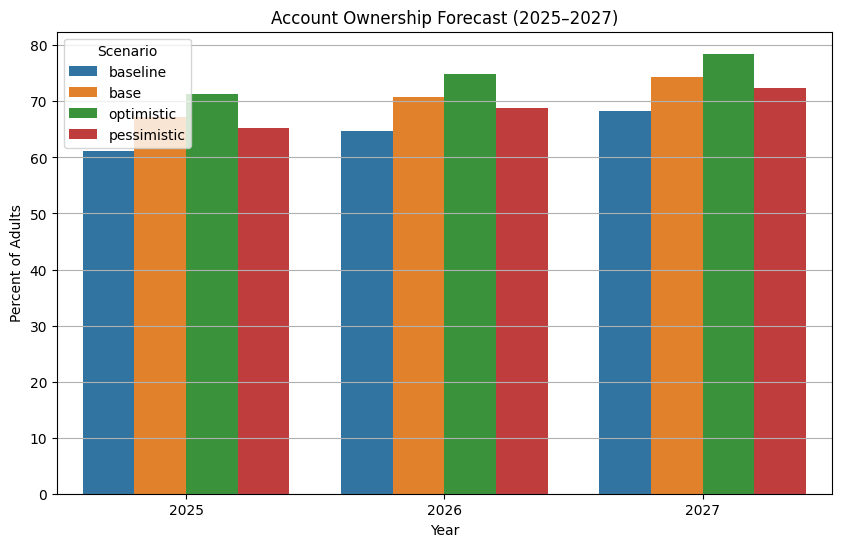

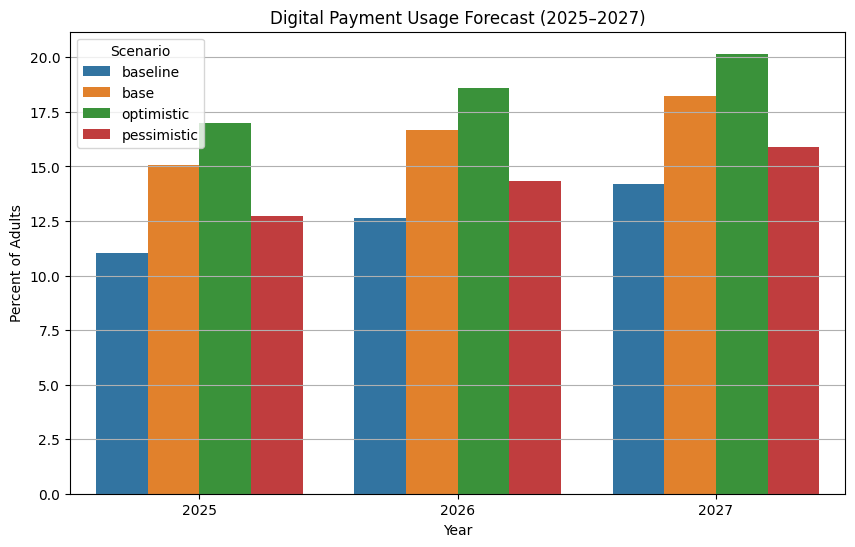

In [8]:
def plot_forecasts_bar(df, title, ylabel):
    df_plot = df.melt(id_vars="year", var_name="Scenario", value_name="Value")
    plt.figure(figsize=(10,6))
    sns.barplot(x="year", y="Value", hue="Scenario", data=df_plot)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.legend(title="Scenario")
    plt.grid(axis='y')
    plt.show()

# Account Ownership
plot_forecasts_bar(forecast_acc, "Account Ownership Forecast (2025–2027)", "Percent of Adults")

# Digital Payment Usage
plot_forecasts_bar(forecast_mm, "Digital Payment Usage Forecast (2025–2027)", "Percent of Adults")


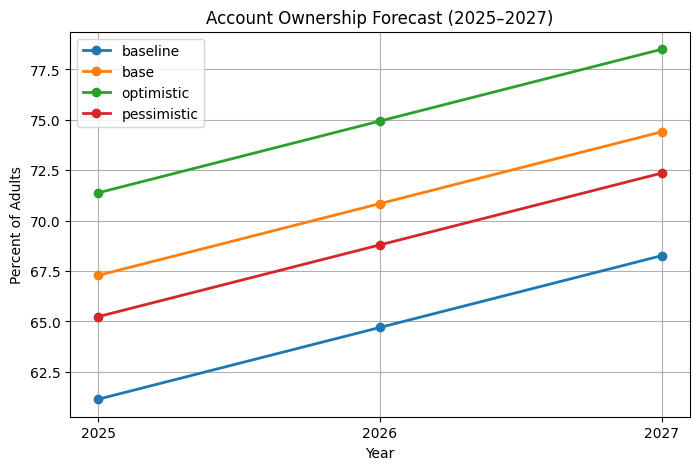

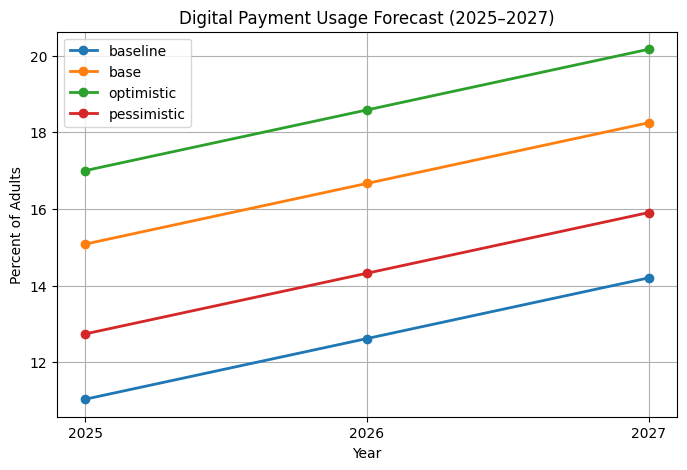

In [9]:
def plot_forecasts(df, title, ylabel):
    plt.figure(figsize=(8,5))
    for col in df.columns[1:]:
        plt.plot(df["year"], df[col], marker='o', linewidth=2, label=col)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(df["year"])
    plt.legend()
    plt.show()

plot_forecasts(forecast_acc, "Account Ownership Forecast (2025–2027)", "Percent of Adults")
plot_forecasts(forecast_mm, "Digital Payment Usage Forecast (2025–2027)", "Percent of Adults")


In [10]:
# Save Account Ownership Forecasts
forecast_acc.to_csv("../data/processed/forecast_account_ownership_2025_2027.csv", index=False)

# Save Digital Payment Usage Forecasts
forecast_mm.to_csv("../data/processed/forecast_digital_payments_2025_2027.csv", index=False)

print("Forecast tables saved successfully!")


Forecast tables saved successfully!


### Interpretation of Forecasts (2025–2027)

**Account Ownership (ACC_OWNERSHIP):**  
- The baseline forecast shows a steady linear increase from historical trends, reaching approximately 68% by 2027.  
- Event-augmented scenarios indicate that product launches such as **Telebirr** and **M-Pesa** can have moderate effects on ownership:  
  - **Optimistic scenario:** Aggressive adoption and supportive policies could increase account ownership by 2–3 percentage points over baseline.  
  - **Pessimistic scenario:** Slower adoption or barriers could reduce the potential gain, keeping ownership closer to baseline.  
- Key uncertainty: Infrastructure gaps, regulatory barriers, and gender disparities may limit ownership growth even if mobile money usage increases.

**Digital Payment Usage (ACC_MM_ACCOUNT / DIGITAL_PAYMENTS):**  
- Event impacts are more pronounced than for ownership. The baseline trend is modest (~14% by 2027), but scenario-adjusted forecasts show substantial variation:  
  - **Optimistic scenario:** Strong event adoption leads to usage reaching up to 20%, reflecting cumulative effects of product launches and interoperability improvements.  
  - **Pessimistic scenario:** Limited adoption keeps usage near baseline.  
- This highlights that digital payments are more sensitive to service availability and event-driven changes than formal account ownership.

**Key Insights:**  
1. **Events matter more for usage than access** — product launches directly boost payment activity but have smaller immediate effects on ownership.  
2. **Scenario analysis provides ranges of expected outcomes**, helping policymakers prioritize interventions.  
3. **Uncertainties:** Infrastructure coverage, financial literacy, and gender gaps are structural limitations that could reduce actual adoption versus model projections.

**Policy Implication:**  
- To accelerate inclusion, complementary policies such as expanding digital ID coverage, increasing smartphone penetration, and targeted inclusion programs (especially for women) are crucial alongside service expansion.
